# PricePredict LSTM Optimization

** Note: The problem with using jupiter notebook to run this code is that there is no way to turn off the output
   of the model summary during training. This is a problem because the output is too large and it bloats jupiter's
   memory. The code works fine in a python script. **
     
Using bayesian optimization to optimize the hyperparameters of the LSTM model.
- Do hidden layers improve the model?

- Latest test that results in the best trend prediction...

## Test Parameters
```
pp.bayesian_optimization(X, y,
                         opt_max_init=100,
                         opt_max_iter=20,
                         pb_lstm_units=(32, 256),
                         pb_lstm_dropout=(0.1, 0.5),
                         pb_adam_learning_rate=(0.001, 0.1),
                         pb_epochs=(100, 300),
                         pb_batch_size=(1, 1024),
                         pb_hidden_layers=(1, 4),
                         pb_hidden_layer_units_1=(16, 256),
                         pb_hidden_layer_units_2=(32, 256),
                         pb_hidden_layer_units_3=(64, 256),
                         pb_hidden_layer_units_4=(128, 256))  
 ```

## Best Hyperparameters 
```
{'adam_learning_rate': 0.007133047958571564,
 'batch_size': 778.4103564949222,
 'epochs': 207.8240175819626,
 'hidden_layer_units_1': 59.5543770288849,
 'hidden_layer_units_2': 33.32458485892822,
 'hidden_layer_units_3': 74.53889954301027,
 'hidden_layer_units_4': 186.98073315100643,
 'hidden_layers': 1.2787028637916622,
 'lstm_dropout': 0.1277210415797052,
 'lstm_units': 240.4579822805544
}
```
 
## Good Trend Prediction 62% tren prediction
```
{'actual_vs_pred': {'mean_trading_range': 0.0,
                    'mean_delta': 0.0,
                    'corr_day_cnt': 639,
                    'corr_days': 639,
                    'uncorr_days': 387,
                    'pct_corr': 62.2807,
                    'pct_uncorr': 37.7193},
 'actual_vs_adj_pred': {'mean_trading_range': 2.07,
                        'mean_delta': 1.42,
                        'corr_days': 639,
                        'uncorr_days': 387,
                        'pct_corr': 62.2807,
                        'pct_uncorr': 37.7193}
}
```


In [1]:

# Import Libraries
import os.path
import numpy as np
import pandas as pd
import logging
import sys
import json
import dill
import pandas as pd
import matplotlib.pyplot as plt
import copy
import berkeleydb as bdb

from pricepredict import PricePredict
from datetime import datetime, timedelta

    
# Use an Object Cache to reduce the prep time for creating and loading the PricePredict objects.
if 'ObjCache' not in globals():
    global ObjCache
    ObjCache = bdb.btopen('ppo_cache.db', 'c')

DirPPO = '../ppo/'
def get_ppo(symbol: str, period: str):
    
    global ObjCache

    # print(f'Type of ObjCache: {type(ObjCache)}')

    ppo_name = symbol + '_' + period

    if bytes(ppo_name, 'latin1') in ObjCache.keys():
        print(f"Using Cached PPO: {ppo_name}")    
        ppo = PricePredict.unserialize(ObjCache[bytes(ppo_name, 'latin1')])
        return 'None', ppo
    
    file_name_starts_with = symbol + '_' + period
    # Find all PPO files for the symbol in the PPO directory
    ppo_files = [f for f in os.listdir(DirPPO) if f.startswith(file_name_starts_with) and f.endswith('.dilz')]
    ppo = None
    if len(ppo_files) > 0:
        # Sort the files by date
        ppo_files.sort()
        # Get the latest PPO file
        ppo_file = ppo_files[-1]
        # Unpickle the PPO file using dilz
        print(f"Reading PPO File: {ppo_file}")
        with open(DirPPO + ppo_file, 'rb') as f:
            f_obj = f.read()
            ppo = PricePredict.unserialize(f_obj)
            
    if ppo is None:
        ppo_file = ppo_name
        print(f"Creating PPO: {ppo_file}")
        ppo = PricePredict(symbol,
                           model_dir='../models/',
                           chart_dir='../charts/',
                           preds_dir='../predictions/',
                           period=period)
        # Train the models on 5 yeas of data...
        end_dt = datetime.now()
        start_dt = end_dt - timedelta(days=5*400)
        end_date = end_dt.strftime('%Y-%m-%d')
        start_date = start_dt.strftime('%Y-%m-%d')
        ppo.fetch_train_and_predict(ppo.ticker, 
                                    start_date, end_date, 
                                    start_date, end_date,
                                    period=PricePredict.PeriodWeekly,
                                    force_training=False,
                                    use_curr_model=True,
                                    save_model=False)
        
    # Cache the ppo
    ObjCache[bytes(ppo_name, 'latin1')] = ppo.serialize_me()

    return ppo_file, ppo


2025-01-24 04:44:35.130779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 04:44:35.149676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 04:44:35.154349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
%matplotlib inline

import logging
import os
import tqdm
from IPython.display import clear_output
from datetime import datetime
from pricepredict import PricePredict

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Create an instance of the price prediction object
pp = PricePredict(model_dir='../models/',
                  chart_dir='../charts/', preds_dir='../predictions/',
                  verbose=False, logger=logger, log_level=logging.ERROR,
                  keras_verbosity=0)

# Load data from Yahoo Finance
ticker = "IBM"
start_date = "2020-01-01"
end_date = "2023-12-31"
# Load and prep data from Yahoo Finance
pp.ticker = ticker
X, y = pp._fetch_n_prep(pp.ticker, start_date, end_date, train_split=0.8)
# Train the model
model, y_pred, mse = pp.train_model(X, y)

# Perform Bayesian optimization
# - Test with all Parameters and 1 2 and 3 hidden layers
pp.model = None
pp.bayes_opt_hypers = None
pp.bayesian_optimization(X, y,
                         opt_max_init=5,
                         opt_max_iter=10,
                         pb_lstm_units=(32, 256),
                         pb_lstm_dropout=(0.1, 0.5),
                         pb_adam_learning_rate=(0.001, 0.1),
                         pb_epochs=(100, 300),
                         pb_batch_size=(1, 1024),
                         pb_hidden_layers=(1, 4),
                         pb_hidden_layer_units_1=(16, 256),
                         pb_hidden_layer_units_2=(32, 256),
                         pb_hidden_layer_units_3=(64, 256),
                         pb_hidden_layer_units_4=(128, 256))

clear_output()

time = datetime.now()
time_str = time.strftime('%Y-%m-%d %H:%M:%S')
title = f"test_bayes_opt all params: {ticker} --  Period {pp.period}  {time_str}"
pred_close = pp.pred[:, 1]
pred_high = pp.pred[:, 2]
pred_low = pp.pred[:, 3]
pp.plot_pred_results(pp.target_close, pp.target_high, pp.target_low,
                     pred_close, pred_high, pred_low, title=title)


Using Cached PPO: IBM_D


('./charts/IBM_D_2025-01-23 00:00:00.png',
 <Figure size 2108.33x1150 with 4 Axes>)

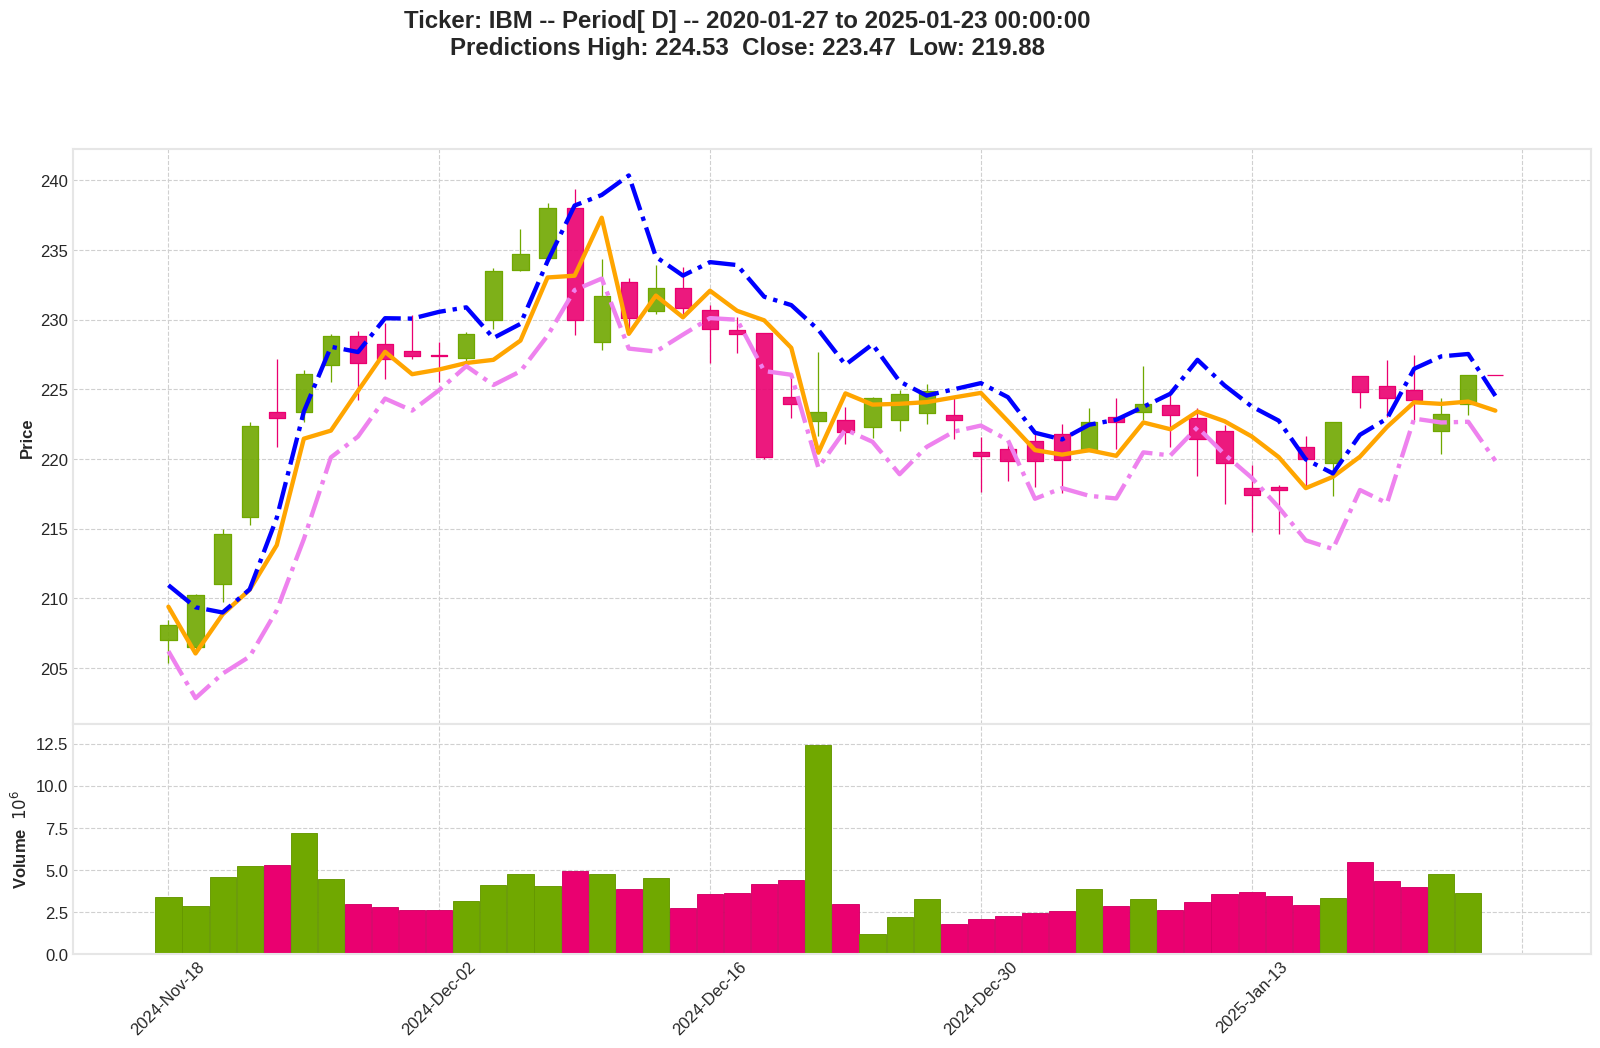

In [5]:

ppo_file, ppo = get_ppo('IBM', 'D')
ppo.gen_prediction_chart()
